In [1]:
%config IPCompleter.use_jedi = False

In [36]:
import glob
import os
import pathlib

import pandas as pd
import numpy as np

import seaborn as sns

In [37]:
log_dir = 'real_world_logs'

In [38]:
reward_filepaths = sorted(glob.glob(os.path.join(log_dir, 'reward*.npy')))
obs_filepaths = sorted(glob.glob(os.path.join(log_dir, 'obs*.npy')))
next_obs_filepaths = sorted(glob.glob(os.path.join(log_dir, 'next_obs*.npy')))
action_filepaths = sorted(glob.glob(os.path.join(log_dir, 'action*.npy')))

trans_err_filepaths = sorted(glob.glob(os.path.join(log_dir, 'translation_err*.npy')))
quat_dist_filepaths = sorted(glob.glob(os.path.join(log_dir, 'quat_dist*.npy')))

start_pose_filepaths = sorted(glob.glob(os.path.join(log_dir, 'start_pose*.npy')))
noise_arr_filepaths = sorted(glob.glob(os.path.join(log_dir, 'noise_arr*.npy')))

In [39]:
"""
Goals with data analysis:

Plot translation error vs quaternion distance
Plot xy position with success rate
"""

'\nGoals with data analysis:\n\nPlot translation error vs quaternion distance\nPlot xy position with success rate\n'

In [40]:
success_arr = np.array([np.load(filepath)[-1] for filepath in reward_filepaths])
noise_arr = np.array([np.load(filepath) for filepath in noise_arr_filepaths])
x_noise_arr = noise_arr[:, 0]
y_noise_arr = noise_arr[:, 1]
z_noise_arr = noise_arr[:, 2]

start_pose_arr = np.array([np.load(filepath) for filepath in start_pose_filepaths])
hand_orientation_quat_arr = start_pose_arr[:, -4:]  # last 4 elems are x,y,z,w quaternion...



In [41]:

# todo: both of these need to be changed after bug fix. remove [-1]
trans_err_arr = np.array([np.load(filepath)[-1] for filepath in trans_err_filepaths])
quat_dist_arr = np.array([np.load(filepath)[-1] for filepath in quat_dist_filepaths])

In [42]:
# put em into a csv, maybe we can use them later

# TODO: no need to number the trials tbh. but can add later

df = pd.DataFrame({'x_noise': x_noise_arr, 'y_noise': y_noise_arr, 'z_noise': z_noise_arr, 'Success': success_arr==True})
df.head()

,x_noise,y_noise,z_noise,Success
0,0.00,0.00,0.0,True
1,0.01,-0.02,0.0,True
2,-0.01,0.00,0.0,True
3,-0.01,0.01,0.0,True
4,-0.01,-0.01,0.0,True


In [50]:
# calculation stuff: do this after defining dataframe

# hardcoded params
base_location = np.array([0, 0, 0])
ideal_grasp_quat = np.array([np.pi/2, 0, 0, np.pi/2])

# step 1: get translation_err. flips to neg value if x is negative
df['trans_err'] = df[['x_noise', 'y_noise', 'z_noise']].apply(lambda x: np.sign(x[0])*np.sqrt(np.sum((x.to_numpy() - base_location)**2)), axis=1)

# step 2: get quat distance
quaternion_dot_prod = np.dot(hand_orientation_quat_arr, ideal_grasp_quat)
angle_difference = np.arccos(quaternion_dot_prod)  # in degrees
quat_distance = np.rad2deg(angle_difference)  # in radians
quat_distance = np.nan_to_num(quat_distance, nan=0, posinf=0, neginf=0)  # for now just set values of positive infinity and negative infinity to also round to 0
df['quat_dist'] = quat_distance

/home/mechagodzilla/kinova_venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


In [51]:
df

,x_noise,y_noise,z_noise,Success,trans_err,quat_dist
0,0.00,0.00,0.0,True,0.000000,0.0
1,0.01,-0.02,0.0,True,0.022361,0.0
2,-0.01,0.00,0.0,True,-0.010000,0.0
3,-0.01,0.01,0.0,True,-0.014142,0.0
4,-0.01,-0.01,0.0,True,-0.014142,0.0
5,-0.01,0.02,0.0,True,-0.022361,0.0
6,-0.01,-0.02,0.0,True,-0.022361,0.0
7,0.02,0.00,0.0,True,0.020000,0.0
8,0.02,0.01,0.0,True,0.022361,0.0
9,0.02,-0.01,0.0,False,0.022361,0.0


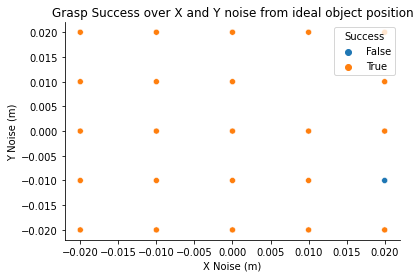

In [52]:
# draw visualization: x and y noise to success rate
xy_noise_success_plot = sns.scatterplot(data=df, x='x_noise', y='y_noise', hue='Success')
xy_noise_success_plot.set(title='Grasp Success over X and Y noise from ideal object position', xlabel='X Noise (m)', ylabel='Y Noise (m)')
sns.despine()

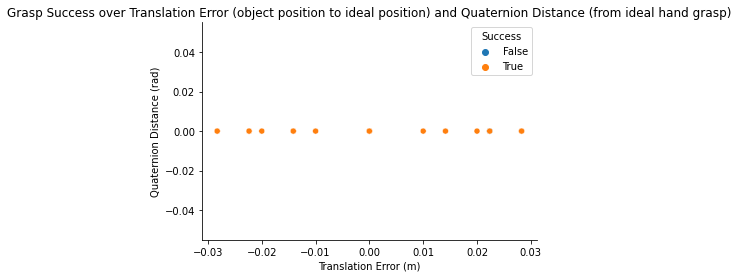

In [53]:
# draw visualization: translation error and quaternion distance to success rate
trans_err_quat_dist_success_plot = sns.scatterplot(data=df, x='trans_err', y='quat_dist', hue='Success')
trans_err_quat_dist_success_plot.set(title='Grasp Success over Translation Error (object position to ideal position) and Quaternion Distance (from ideal hand grasp)', xlabel='Translation Error (m)', ylabel='Quaternion Distance (rad)')
sns.despine()

In [16]:
# # TODO: make results directory first...
# self._log_dir = log_dir
# results_dir = os.path.join(self._log_dir, 'results/')

results_path = Path(results_dir)
results_path.mkdir(parents=True, exist_ok=True)


NameError: name 'Path' is not defined

In [17]:

# save data to a csv
df.to_csv(os.path.join(results_dir, 'results' + '.csv'))

# save plots to a file
xy_noise_success_plot.savefig(os.path.join(results_dir, 'xy_noise_success' + '.csv'))
trans_err_quat_dist_success_plot.savefig(os.path.join(results_dir, 'trans_err_quat_dist_success' + '.csv'))


NameError: name 'results_dir' is not defined

In [82]:
log_dir = 'positional_noise_test'
episode_dir = os.path.join(log_dir, 'episodes/')

In [83]:
reward_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'reward*.npy')))
obs_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'obs*.npy')))
next_obs_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'next_obs*.npy')))
action_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'action*.npy')))

trans_err_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'translation_err*.npy')))
quat_dist_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'quat_dist*.npy')))

start_pose_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'start_pose*.npy')))
noise_arr_filepaths = sorted(glob.glob(os.path.join(episode_dir, 'noise_arr*.npy')))

In [84]:
"""
Goals with data analysis:

Plot translation error vs quaternion distance
Plot xy position with success rate
"""

'\nGoals with data analysis:\n\nPlot translation error vs quaternion distance\nPlot xy position with success rate\n'

In [85]:
success_arr = np.array([np.load(filepath)[-1] for filepath in reward_filepaths])
noise_arr = np.array([np.load(filepath) for filepath in noise_arr_filepaths])
x_noise_arr = noise_arr[:, 0]
y_noise_arr = noise_arr[:, 1]
z_noise_arr = noise_arr[:, 2]

start_pose_arr = np.array([np.load(filepath) for filepath in start_pose_filepaths])
hand_orientation_quat_arr = start_pose_arr[:, -4:]  # last 4 elems are x,y,z,w quaternion...



In [24]:

# todo: both of these need to be changed after bug fix. remove [-1]
trans_err_arr = np.array([np.load(filepath) for filepath in trans_err_filepaths])
quat_dist_arr = np.array([np.load(filepath) for filepath in quat_dist_filepaths])

In [86]:
# put em into a csv, maybe we can use them later

# TODO: no need to number the trials tbh. but can add later

edge_df = pd.DataFrame({'x_noise': x_noise_arr, 'y_noise': y_noise_arr, 'z_noise': z_noise_arr, 'Success': success_arr==True})
edge_df.head()

,x_noise,y_noise,z_noise,Success
0,0.00,0.03,0.0,True
1,0.03,0.03,0.0,True
2,0.02,0.03,0.0,True
3,-0.03,0.03,0.0,False
4,-0.02,0.03,0.0,True


In [62]:
df[['x_noise', 'y_noise', 'z_noise']]

,x_noise,y_noise,z_noise
0,0.00,0.00,0.0
1,0.01,-0.02,0.0
2,-0.01,0.00,0.0
3,-0.01,0.01,0.0
4,-0.01,-0.01,0.0
5,-0.01,0.02,0.0
6,-0.01,-0.02,0.0
7,0.02,0.00,0.0
8,0.02,0.01,0.0
9,0.02,-0.01,0.0


In [27]:
df[['x_noise', 'y_noise', 'z_noise']].apply(lambda x: (x.to_numpy()), axis=1)

0         [0.0, 0.0, 0.0]
1      [0.01, -0.02, 0.0]
2       [-0.01, 0.0, 0.0]
3      [-0.01, 0.01, 0.0]
4     [-0.01, -0.01, 0.0]
5      [-0.01, 0.02, 0.0]
6     [-0.01, -0.02, 0.0]
7        [0.02, 0.0, 0.0]
8       [0.02, 0.01, 0.0]
9      [0.02, -0.01, 0.0]
10      [0.02, 0.02, 0.0]
11       [0.0, 0.01, 0.0]
12     [0.02, -0.02, 0.0]
13      [-0.02, 0.0, 0.0]
14     [-0.02, 0.01, 0.0]
15    [-0.02, -0.01, 0.0]
16     [-0.02, 0.02, 0.0]
17    [-0.02, -0.02, 0.0]
18      [0.0, -0.01, 0.0]
19       [0.0, 0.02, 0.0]
20      [0.0, -0.02, 0.0]
21       [0.01, 0.0, 0.0]
22     [0.01, -0.01, 0.0]
23      [0.01, 0.02, 0.0]
dtype: object

In [63]:
# calculation stuff: do this after defining dataframe

# hardcoded params
base_location = np.array([0, 0, 0])
ideal_grasp_quat = np.array([np.pi/2, 0, 0, np.pi/2])

# step 1: get translation_err. flips to neg value if x is negative
edge_df['trans_err'] = edge_df[['x_noise', 'y_noise', 'z_noise']].apply(lambda x: np.sign(x[0])*np.sqrt(np.sum((x.to_numpy() - base_location)**2)), axis=1)
# edge_df['trans_err'] = df[['x_noise', 'y_noise', 'z_noise']].apply(lambda x: x, axis=0)

# step 2: get quat distance
quaternion_dot_prod = np.dot(hand_orientation_quat_arr, ideal_grasp_quat)
angle_difference = np.arccos(quaternion_dot_prod)  # in degrees
quat_distance = np.rad2deg(angle_difference)  # in radians
quat_distance = np.nan_to_num(quat_distance, nan=0, posinf=0, neginf=0)  # for now just set values of positive infinity and negative infinity to also round to 0
edge_df['quat_dist'] = quat_distance

/home/mechagodzilla/kinova_venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arccos
  del sys.path[0]


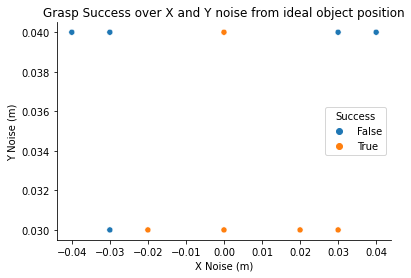

In [64]:
# draw visualization: x and y noise to success rate
xy_noise_success_plot = sns.scatterplot(data=edge_df, x='x_noise', y='y_noise', hue='Success')
xy_noise_success_plot.set(title='Grasp Success over X and Y noise from ideal object position', xlabel='X Noise (m)', ylabel='Y Noise (m)')
sns.despine()

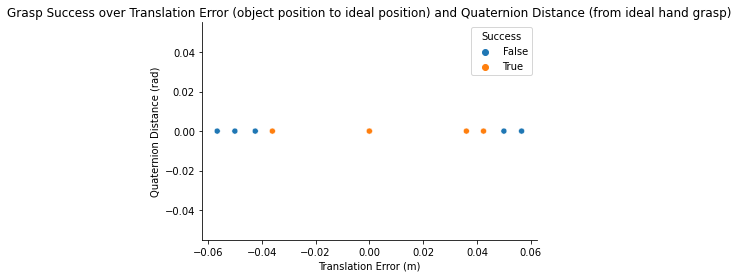

In [65]:
# draw visualization: translation error and quaternion distance to success rate
trans_err_quat_dist_success_plot = sns.scatterplot(data=edge_df, x='trans_err', y='quat_dist', hue='Success')
trans_err_quat_dist_success_plot.set(title='Grasp Success over Translation Error (object position to ideal position) and Quaternion Distance (from ideal hand grasp)', xlabel='Translation Error (m)', ylabel='Quaternion Distance (rad)')
sns.despine()

In [ ]:
# TODO: make results directory first...
self._log_dir = log_dir
results_dir = os.path.join(self._log_dir, 'results/')

results_path = Path(results_dir)
results_path.mkdir(parents=True, exist_ok=True)


In [ ]:

# save data to a csv
df.to_csv(os.path.join(results_dir, 'results' + '.csv'))

# save plots to a file
xy_noise_success_plot.savefig(os.path.join(results_dir, 'xy_noise_success' + '.csv'))
trans_err_quat_dist_success_plot.savefig(os.path.join(results_dir, 'trans_err_quat_dist_success' + '.csv'))


In [72]:
merged_df = pd.concat((df, edge_df))
merged_df

,x_noise,y_noise,z_noise,Success,trans_err,quat_dist
0,0.00,0.00,0.0,True,0.000000,0.0
1,0.01,-0.02,0.0,True,0.022361,0.0
2,-0.01,0.00,0.0,True,-0.010000,0.0
3,-0.01,0.01,0.0,True,-0.014142,0.0
4,-0.01,-0.01,0.0,True,-0.014142,0.0
5,-0.01,0.02,0.0,True,-0.022361,0.0
6,-0.01,-0.02,0.0,True,-0.022361,0.0
7,0.02,0.00,0.0,True,0.020000,0.0
8,0.02,0.01,0.0,True,0.022361,0.0
9,0.02,-0.01,0.0,False,0.022361,0.0


[Text(0.5, 1.0, 'Grasp Success over X and Y noise from ideal object position'),
 Text(0.5, 0, 'X Noise (m)'),
 Text(0, 0.5, 'Y Noise (m)')]

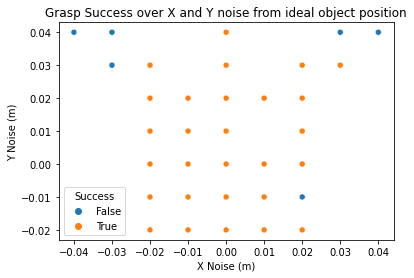

In [73]:
# draw visualization: x and y noise to success rate
xy_noise_success_plot = sns.scatterplot(data=merged_df, x='x_noise', y='y_noise', hue='Success')
xy_noise_success_plot.set(title='Grasp Success over X and Y noise from ideal object position', xlabel='X Noise (m)', ylabel='Y Noise (m)')


[Text(0.5, 1.0, 'Grasp Success over Translation Error (object position to ideal position) and Quaternion Distance (from ideal hand grasp)'),
 Text(0.5, 0, 'Translation Error (m)'),
 Text(0, 0.5, 'Quaternion Distance (rad)')]

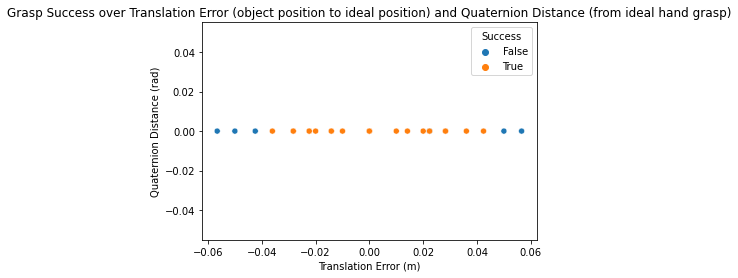

In [74]:
# draw visualization: translation error and quaternion distance to success rate
trans_err_quat_dist_success_plot = sns.scatterplot(data=merged_df, x='trans_err', y='quat_dist', hue='Success')
trans_err_quat_dist_success_plot.set(title='Grasp Success over Translation Error (object position to ideal position) and Quaternion Distance (from ideal hand grasp)', xlabel='Translation Error (m)', ylabel='Quaternion Distance (rad)')


In [76]:
xy_noise_success_plot.get_figure().savefig()

TypeError: savefig() missing 1 required positional argument: 'fname'

In [81]:

# save data to a csv
merged_df.to_csv(os.path.join('trial_1_results' + '.csv'))

# save plots to a file
xy_noise_success_plot.get_figure().savefig(os.path.join('trial_1_xy_noise_success' + '.png'))
trans_err_quat_dist_success_plot.get_figure().savefig(os.path.join('trial_1_trans_err_quat_dist_success' + '.png'))
